# Wstępne przetwarzanie obrazu

Wczytaj niezbędne biblioteki.

In [1]:
import cv2 as cv
import os
from matplotlib.image import imsave
import seaborn as sns
%matplotlib inline
import sys
notebook_dir = os.getcwd()
nb_dir = os.path.join(os.path.split(os.getcwd())[0], 'Application')
if nb_dir not in sys.path:
    sys.path.append(nb_dir)

Dokonaj wstępnego przetwarzania obrazu:
- wczytanie bazy danych,
- odnalezienie twarzy metodą Viola-Jones,
- 'wycięcie' twarzy ze znalezionego zdjęcia oraz przeskalowanie go do stałych wymiarów,
- normalizacja poziomów jasności (wartości od 0 do 255),
- zapis przetworzonych zdjęć.

In [2]:
scale_factor = 1.05
min_neighbors = 3

def image_selection():
    """Select images where faces are detected, crop and normalize them and save them to
    savepath directory."""

    rootdir = os.getcwd()
    file_dir = os.path.join(rootdir, '..', 'Data', 'raw_faces_data')
    savepath = os.path.join(file_dir, '..', 'detected_faces')

    face_cascade = cv.CascadeClassifier('haarcascade_frontalface_default.xml')

    id = 100

    for subdir, dirs, files in os.walk(file_dir):

        for file in files:

            im = cv.imread(os.path.join(subdir, file), 0)
            faces = face_cascade.detectMultiScale(im, scale_factor, min_neighbors)

            for (x, y, w, h) in faces:
                crop_img = im[y:y + h, x:x + w]
                crop_img = cv.resize(crop_img, dsize=(86, 86), interpolation=cv.INTER_CUBIC)
                crop_img = cv.normalize(crop_img, crop_img, 0, 255, cv.NORM_MINMAX)
                #imsave(os.path.join(savepath, '{}.jpg'.format(id)), crop_img, cmap=plt.cm.bone)
                cv.imwrite(os.path.join(savepath, '{}_{}.pgm'.format(id, subdir.split('\\s')[1])),
                           crop_img)
                id += 1

                # Plot the images with detected faces
                # cv.rectangle(im, (x, y), (x + w, y + h), (0, 255, 0), 2)
                # cv.imshow('img', im)
                # cv.waitKey(0)
                # cv.destroyAllWindows()

# Wyznaczanie 'Twarzy własnych'

## *Wczytanie bazy danych*

Wczytywanie zdjęć, zapisanie informacji na temat ilości zdjęć, ich wymiarów oraz obliczenie 'twarzy średniej' na podstawie danych ze zdjęć.

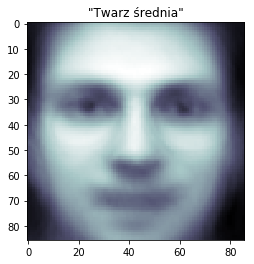

In [3]:
from FaceRecognition_eigenfaces import FaceRecognitionEigenfaces
from FaceRecognition_ImagePreprocessing import image_selection

# Create object containing functions to calculate eigenfaces
fr = FaceRecognitionEigenfaces()
# Import images
fr.get_images()

import matplotlib.pyplot as plt
plt.imshow(fr.mean_img, cmap=plt.cm.bone)
plt.title('"Twarz średnia"')
plt.show()

## *Oblicz twarze własne* 

Procedura obliczenia twarzy własnych jest następująca:
- Mając M zdjęć, każde o wymiarach NxN tworzona jest z nich macierz o wymiarach A = M x N<sup>2</sup>.
- Następnie należy obliczyć macierz kowariancji. Z definicji tworzona jest ona jako AA<sup>T</sup>, jednakże z racji jej rozmiaru (N<sup>2</sup>xN<sup>2</sup>) używamy macierzy kowariancji A<sup>T</sup>A (o wymiarach MxM), która będąc przemnożona lewostronnie przez macierz A pozwoli na otrzymanie twarzy własnych w sposób o mniejszej złożoności obliczeniowej. 
- Wybrane wektory własne reprezentują 99 % wariancji danych a ich liczba to 15 (gdzie wektor własny to twarz własna).

**Dla zainteresowanych, dowód poniżej.**

Consider the matrix A<sup>T</sup>A (MxM matrix) 

Compute the eigenvectors v<sub>i</sub> of A<sup>T</sup>A:

<h5 align="center">A<sup>T</sup>Av<sub>i</sub> = µ<sub>i</sub>v<sub>i</sub></h5>

The relationship between us<sub>i</sub> and v<sub>i</sub> is:

<h5 align="center">A<sup>T</sup> Av<sub>i</sub> =  µ<sub>i</sub>v<sub>i</sub> => AA<sup>T</sup> Av<sub>i</sub> =  µ<sub>i</sub>Av<sub>i</sub> =>

<h5 align="center">CAv<sub>i</sub> =  µ<sub>i</sub>Av<sub>i</sub> or  Cu<sub>i</sub> =  µ<sub>i</sub>u<sub>i</sub> &nbsp; &nbsp; &nbsp; &nbsp;where  &nbsp; u<sub>i</sub> = Av<sub>i</sub></h5>

Thus, AA<sup>T</sup> and A<sup>T</sup> A have the same eigenvalues and their eigenvectors are related as follows:

<h5 align="center">u<sub>i</sub> = Av<sub>i</sub></h5> 

1. AA<sup>T</sup> can have up to N<sup>2</sup>  eigenvalues and eigenvectors. 

2. A<sup>T</sup>A can have up to M eigenvalues and eigenvectors.

3. The M eigenvalues of A<sup>T</sup>A (along with their corresponding eigenvectors) correspond to the M largest eigenvalues of AA<sup>T</sup> (along with their corresponding eigenvectors).

In [4]:
# Find eigenfaces
plt.rcParams['figure.figsize'] = [15, 10]
fr.get_eigenfaces()

#gdzie get_eigenfaces:
def get_eigenfaces(self):

    """ eigenfaces_n is passed as a parameter (percentage of variance to obtain
    and it is changed here to the number of eigenfaces obtained."""

    # Subtract the mean from every flattened image and prepare covariance matrix
    # equal to  L^T*L  for computational efficiency
    self.image_matrix_flat = np.array([x - self.mean_img.flatten() for x in self.image_matrix_flat.transpose()]).transpose()
    cov_matrix = np.matmul(self.image_matrix_flat.transpose(), self.image_matrix_flat)
    cov_matrix /= self.image_count

    # Calculate and choose eigenvectors corresponding to the highest eigenvalues
    pca = PCA(n_components = self.eigenfaces_n)
    pca.fit(cov_matrix)

    # Left multiply to get the correct eigenvectors
    eigenvectors = np.matmul(self.image_matrix_flat, np.transpose(pca.components_))
    pca = PCA(n_components = self.eigenfaces_n)
    pca.fit(eigenvectors.transpose())
    self.eigenfaces_flat = pca.components_
    self.eigenfaces_n = len(pca.components_)


    # Calculate weights representing faces in new dimensional space
    # and reshape eigenface matrix to have
    # number_of_faces X shape1 X shape 2
    self.face_weights = np.matmul(self.image_matrix_flat.transpose(), self.eigenfaces_flat.transpose())
    self.eigenfaces = np.array(self.eigenfaces_flat).reshape((self.eigenfaces_n, self.image_shape, self.image_shape))

In [5]:
print("Liczba twarzy własnych jest równa: {}".format(len(fr.eigenfaces)))

Liczba twarzy własnych jest równa: 21


Dodatkowo, po obliczeniu twarzy własnych obliczana jest reprezentacja każdego zdjęcia, twarzy, w nowej wymiarowości otrzymanej dzięki twarzom własnym. Mając E twarzy własnych każda z twarzy może być opisana E wartościami i jest to równoważne wektorowi wartości bądź punktowi w przestrzeni wielowymiarowej (w tym wypadku przestrzeni piętnastowymiarowej).

W celu otrzymania wartości dla tych twarzy obliczana jest macierz Grama, czyli iloczyn macierzy oraz macierzy transponowanej, której wynikiem jest macierz składająca się z iloczynów skalarnych zbioru owych wektorów. W tym przypadku pierwszy element jest macierzą pikseli MxN<sup>2</sup>, zaś drugi reprezentuje twarze własne i jest on wymiarów N<sup>2</sup>xE, gdzie E - ilość twarzy własnych. Dzięki temu otrzymujemy macierz MxE, czyli dla każdego zdjęcia M mamy E wartości, które opisują twarz na zdjęciu.

## *Wizualizacja wyników* 

Prezentacja pierwszych dziewięciu twarzy własnych, gdzie pierwsza twarz najlepiej opisuje różnice pomiędzy twarzami (reprezentuje największą wariancję zbioru danych) i z każdą kolejną twarzą własną ta wartość maleje.

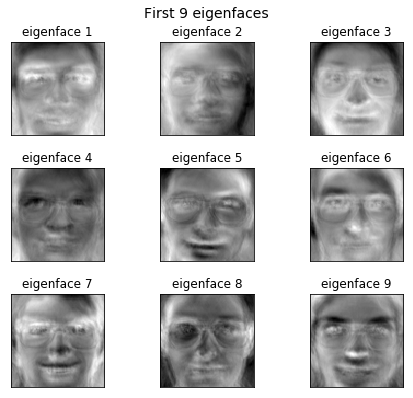

In [8]:
from auxiliary.aux_plotting import reconstruction_fast, plot_eigenfaces, \
    reconstruction, plot_faces_2components, compare_plot, reconstruction_manual, \
    plot_tsne, plot_eigenfaces_variance

plot_eigenfaces(fr)

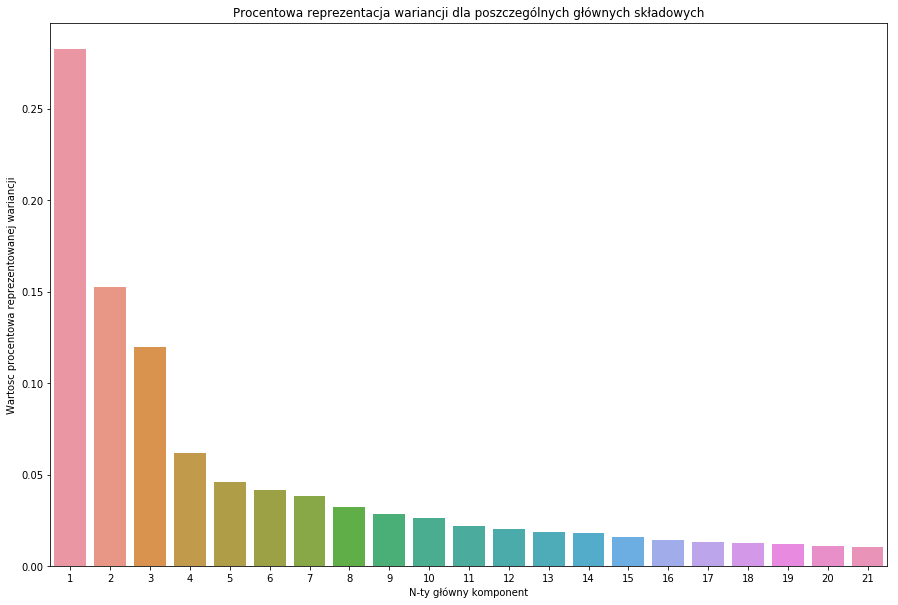

In [10]:
plot_eigenfaces_variance(fr)

Kolejny wykres prezentuje twarze na wykresie gdzie na osi X jest wartość pierwszej głównej składowej, zaś na osi Y drugiej głównej składowej (wartości, wagi przynależące do pierwszej i drugiej twarzy własnej).

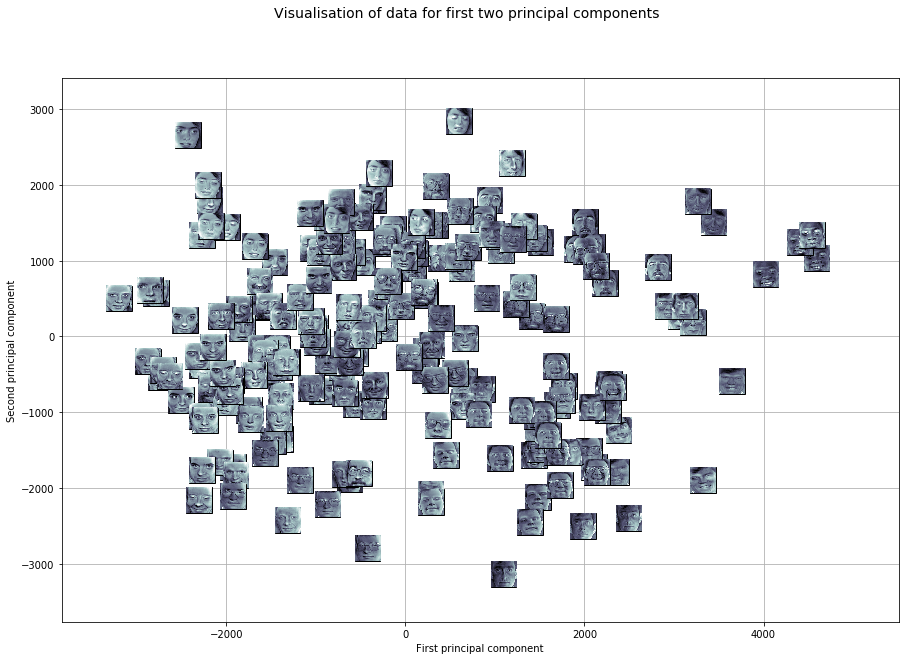

In [11]:
plt.rcParams['figure.figsize'] = [15, 10]
plot_faces_2components(fr)

Jak widać na wykresie, pierwsza składowa główna odpowiada w dużej mierze za jasność twarzy, dlatego też jaśniejsze twarze znajdują się po lewej, zaś ciemniejsze zdjęcia po prawej. Drugi komponent nie jest już tak łatwy do zdefiniowania i rozróżnia on twarze w nieoczywisty sposób.

Dodatkowo, zdjęcia twarzy należące do jednej osoby są niedaleko siebie - niestety, używając wyłącznie dwóch składowych głównych nie jest możliwe odseparowanie twarzy różnych osób od siebie.

Zamiast używania składowych głównych do wizualizacji wyników można również użyć stochastycznej metoda porządkowania sąsiadów w oparciu o rozkład (t-SNE), która pozwala wizualizować dane wysokowymiarowe. Metoda przekształca odległości euklidesowe pomiędzy punktami w przestrzeni oryginalnej w sposób, który umożliwia względne zachowanie odległości między nimi i przedstawienie ich w przestrzeni o zredukowanej wymiarowości - tutaj w 2D.

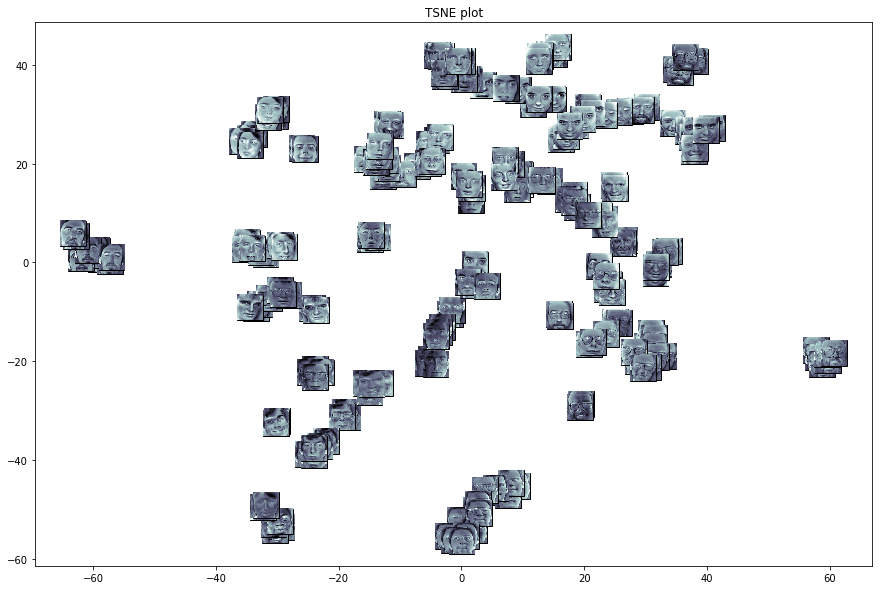

In [12]:
plt.rcParams['figure.figsize'] = [15, 10]
fr.stochastic_neighbour_embedding()

Jak widać na wykresie, zdjęcia twarzy należące do jednej osoby występują bezpośrednio obok siebie.

Z racji utraty pewnej części informacji w trakcie obliczania twarzy własnych (99% wariancji danych) nie da się odwzorować ich w idealny sposób. Próba rekonstrukcji twarzy na podstawie twarzy własnych jest pokazana poniżej.

In [13]:
from IPython.display import HTML
HTML('<img src="visualization/reconstruction_15ev.gif">')

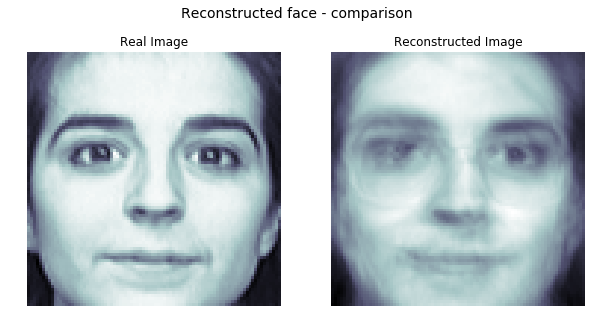

In [14]:
plt.rcParams['figure.figsize'] = [10, 5]
reconstruction_fast(fr)

Mając już zbiór danych reprezentujących twarze możemy spróbować znaleźć twarz osoby w zbiorze, używając innego zdjęcia. W najprostszym przypadku może to zostać osiągnięte za pomocą metody najbliższego sąsiada. Policzy on odległość euklidesową pomiędzy punktami(zdjęciami) i wybierze te o najmniejszej odległości od dodanego zdjęcia.

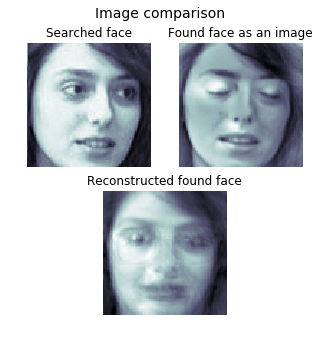

In [15]:
from FaceRecognition_newfaces import EigenfaceRecognitionNewfaces

efr = EigenfaceRecognitionNewfaces(data=fr)
efr.find_me_face(os.path.join(efr.newfacedir, "new_face.jpg"))

Oczywiście istnieją lepsze metody niż metoda najbliższego sąsiada. Jedną z takich metod jest metoda k-nearest neighbours, która szuka k sądiadów i na ich podstawie ocenia do którego zbioru należą dane.

Dla wizualizacji, w pierwszej kolejności zostaną dodane 3 zdjęcia jednej osoby w sposób, który od razu klasyfikuje te dane jako jedna osoba. Następnie zostaną dodane kolejne dwa zdjęcia i program powinien rozpoznać, czy dana osoba jest już w bazie danych, czy nie.

In [16]:
# Dodawanie zdjec przynalezacych do jednej osoby
efr.add_face(os.path.join(efr.newfacedir,'ja1.jpg'), 999) # 999 oznacza id danej osoby
efr.add_face(os.path.join(efr.newfacedir,'ja2.jpg'), 999)
efr.add_face(os.path.join(efr.newfacedir,'ja3.jpg'), 999)
efr.add_face(os.path.join(efr.newfacedir,'ja4.jpg'))
efr.add_face(os.path.join(efr.newfacedir,'ja5.jpg'))

### [[3113.59365789 3252.71192949 3545.9227395  3559.7369928  3756.52492174]] [37 37 13 13  5]
New face detected or classified improperly
### [[1225.96363272 3360.25932517 3433.70271383 4162.60207069 4182.66374706]] [999  37  37  13  13]
Face was detected. Person in the database.
### [[1818.22123956 2442.79637192 3184.98112172 3210.64013059 3326.28995638]] [999 999  13  13   5]
Face was detected. Person in the database.
### [[1797.36125626 1881.66267766 2482.05374361 2683.25950162 2914.08239718]] [999 999 999  37  37]
Face was detected. Person in the database.
### [[1823.89168286 2109.62722037 2781.61380055 3234.98041261 3440.64957718]] [999 212 999 999   5]
New face detected or classified improperly
